In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from signal_tl import Signal, Predicate, compute_robustness, F, G
from signal_tl.plot import plot_robustness, plot_trace, plot_negative_span

plt.rcParams['figure.figsize'] = [10, 4]

## Glossary

- *Time horizon*: positive real value $T$
- *Signal*: a function $\sigma: \mathbb{R} \mapsto [0, T]$
- *Sampling points*: an ascending series $t_1 \le \dots \le t_N$, where $t_1=0$ and $t_N < T$
- *Control points*: a (small) subset of sampling points $t_{c_1}, \le t_{c_M}$, whose size is $M$
- *Sample sequence*: a sequence $(t_1, v_1), \dots. (t_N, v_N)$, where $\{t_i\}_i$ are sampling points and $v_i \in \mathbb{R}$ 

REMARK: We assume a sample sequence represents a piecewise linear signal.

In [2]:
# Hyperparameters

time_step = 0.1
time_horizon = 10
n_cp = 5 

In [3]:
# utils

def pick_n_dividing_points(target: np.ndarray, n: int, force_include_end = False) -> np.ndarray:
    if force_include_end:
        q = len(target) / (n - 1)
        idx = [*[int(np.floor(i * q)) for i in range(n-1)], -1]
    else:
        q = len(target) / n
        idx = [int(np.floor(i * q)) for i in range(n)]
    return target[idx]

def eq(predicate, value):
    epsilon = 1e-3
    return (predicate > value - epsilon) & (predicate < value + epsilon)

def plot_signal(signal):
    plt.plot(signal.times, signal.values, '.-')

def plot_trace(trace, title=None, sharey=True, show_markers=False, **figure_args):
    fig, ax = plt.subplots(len(trace), sharex=True, sharey=sharey, **figure_args)
    for i, (name, signal) in enumerate(trace.items()):
        if show_markers:
            ax[i].plot(signal.times, signal.values, '.-')
        else:
            ax[i].plot(signal.times, signal.values, '-')
        ax[i].set_title(name)
    if title:
        fig.suptitle(title, color='red')

Generate sampling points periodically.

And we pick control points following the rules below (the is not necessary but I guess a good practice).

- Each control points are picked from sampling points
- `cp[0] = 0`
- `cp[-1] = sampling_points[-1]`
- Control points devide $[0, T]$ as evenly as possible 

In [4]:
sampling_points = np.arange(0, time_horizon, time_step)
control_points = pick_n_dividing_points(sampling_points, n_cp, force_include_end=True)


An $M$-dimensional value $(v_1,\dots, v_M) \in \mathbb{R}^M$ specifies $\sigma(t_{c_1}) = v_1, \dots, \sigma(t_{c_M}) = v_M$.
For the values at the other points, assuming piecewise-constant or piecewise-linear is standard way in literature.

We here adopt another approach, because in such formalisms, there is no stable way to define its *derivatives*, which commonly appears in our STL formulas like `x < 2 /\ x' > 0`.

Especially,
- Higher-order derivatives are nonsense in such formalisms
- [Finite difference](https://en.wikipedia.org/wiki/Finite_difference) method poorly approximates the derivatives, since the time delta $t_{c_{i+1}} - t_{c_i}$ is not so small.



Thus, we try to fit a cubic [spline curve function](https://en.wikipedia.org/wiki/B-spline) $B(t)$ on    the control points.
$B(t)$ is a continuous piecewise-polynomial function with the properties:
- $B(t_{c_i}) = v_i$
- $B(t), B'(t), B''(t)$ are continuous
- $B'''(t)$ is not continuous (I guess this is not significant)

After that we can consistently define $\sigma(t), \dots, \sigma'''(t)$ (straightforward from $B(t), \dots, B'''(t)$).

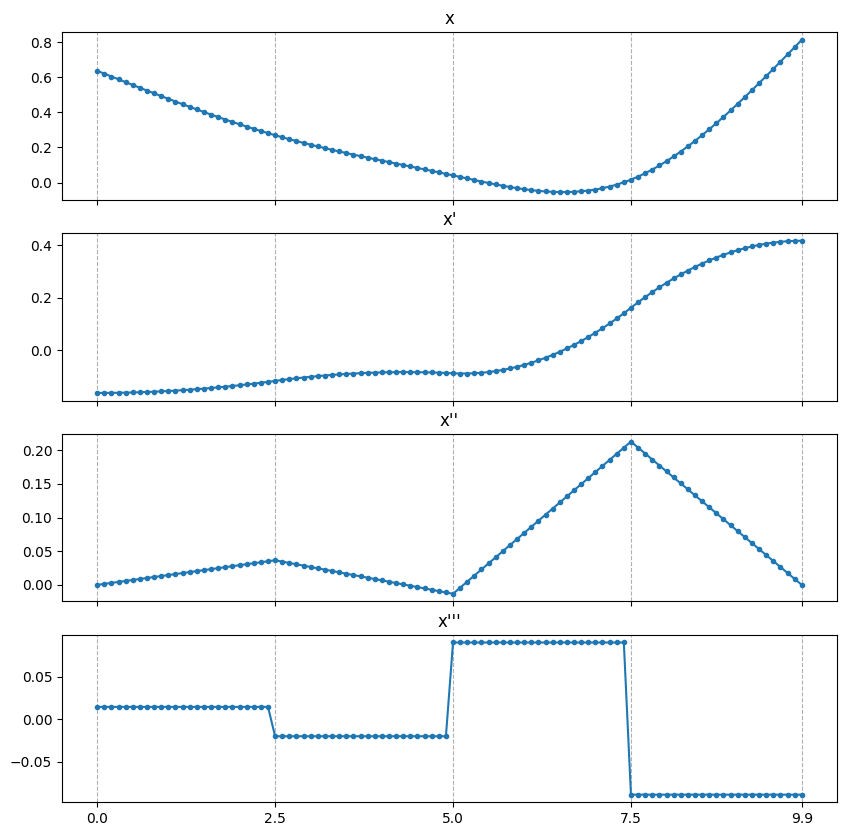

In [5]:
# Signal generation

def generate_diff_signals(
    symbol: str,
    control_points,
    valuation,
    times,
    max_deriv_order=0
):
    if max_deriv_order < 0:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Derivative order shoud be a non-negative integer.")
    elif max_deriv_order > 3:
        raise ValueError("max_deriv_order=#{max_deriv_order} given."
                         "Currently only n<=3 order of derivatives are supported.")

    spline = scipy.interpolate.CubicSpline(
        control_points,
        valuation,
        bc_type="natural",  # boundary condition. f''(0) == f''(T) == 0.
    )
    def nth_deriv(n):
        return Signal(spline(times, n), times)
    return {
        (symbol + "'" * i): nth_deriv(i) 
        for i in range(max_deriv_order + 1)
    }

sample_trace = generate_diff_signals("x", control_points, np.random.default_rng(0).random(n_cp), sampling_points, max_deriv_order=3)

plot_trace(sample_trace, sharey=False, show_markers=True, figsize=[10,10])

for ax in plt.gcf().axes:  # Grid on control points
    ax.set_xticks(control_points)
    ax.grid(axis="x", linestyle="--")

In [6]:
# Spec definition

danger = (Predicate("y - x") < 10)
carx = ((Predicate("x'") > 5) & (Predicate("x'") < 27) & 
        (Predicate("x''") > -3) & (Predicate("x''") < 3) &
        (Predicate("x'''") > -5) & (Predicate("x'''") < 5))
cary = ((Predicate("y'") > 5) & (Predicate("y'") < 27) & 
        (Predicate("y''") > -3) & (Predicate("y''") < 3) &
        (Predicate("y'''") > -5) & (Predicate("y'''") < 5))

sim = (eq(Predicate("x"), 0) & eq(Predicate("y"), 45) & 
        F(danger, (0, 7)) & 
        G(carx & cary & (Predicate("y - x") > 0))
)

In [7]:
# R^{2M} -> {Two signals over [0, T]}

def generate_trace(control_points, sampled_point, times):
    valuation_x = sampled_point[:len(control_points)]
    valuation_y = sampled_point[len(control_points):]
    xs = generate_diff_signals("x", control_points, valuation_x, times, max_deriv_order=3)
    ys = generate_diff_signals("y", control_points, valuation_y, times, max_deriv_order=3)
    return {
        **xs,
        **ys,
        "y - x": Signal(np.array(ys["y"].values) - np.array(xs["x"].values), times),
    }

Optimization part.

In [8]:
from cmaes import CMA
import time

search_dim = len(control_points) * 2  # Two signals are generated

optimizer = CMA(
    mean=np.zeros(search_dim),  # Initial mean
    sigma=1.3,  # Initial standard deviation. sigma=1.3 is OK for most purposes.
    bounds=None,  # Lower and upper boundaries can be specified
    )

history = []
falsified_traces = []
generation = 0

t1 = time.time()

# Exemplification is minimization of "[[signal, ~sim]]"
while optimizer.should_stop() or len(falsified_traces) < 5:  # Continue our search until 5 feasibles are found
    solutions = []
    for _ in range(optimizer.population_size):  # Batch-evaluation
        x = optimizer.ask()
        trace = generate_trace(control_points, x, sampling_points)
        value = compute_robustness(~sim, trace).at(0)
        history.append((x, trace, value))
        if value < 0:
            falsified_traces.append(trace)
            print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
        solutions.append((x, value))
    optimizer.tell(solutions)

    generation += 1

elapsed = time.time() - t1

#249 -0.00047340805861750823 (x1=0.00015464999438672767, x2 = 35.842227388587844)
#281 -0.00028420043253163385 (x1=-0.00048507542865562094, x2 = 34.66264633593253)
#287 -0.000206729636062164 (x1=-0.0005918529200364309, x2 = 34.2089487512948)
#295 -0.00046940648573457454 (x1=-0.0005305935142654255, x2 = 34.85495488478136)
#298 -0.0004259557351602439 (x1=-0.0002777239828548686, x2 = 34.62525692800195)


In [9]:
elapsed

2.37713623046875

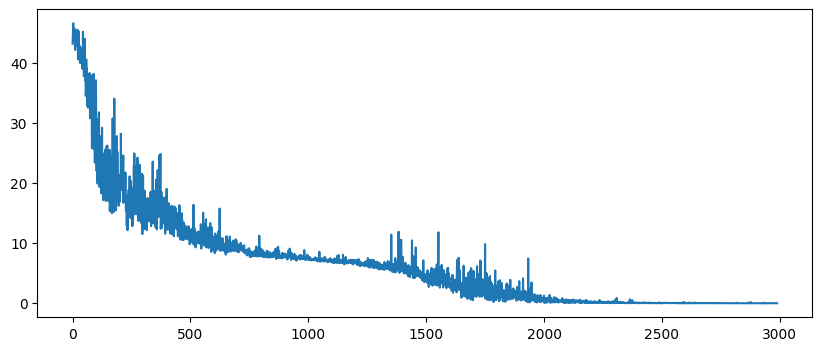

In [10]:
# Optimization history

plt.plot([robustness for (_, _, robustness) in history])

Inspect the best signal found.

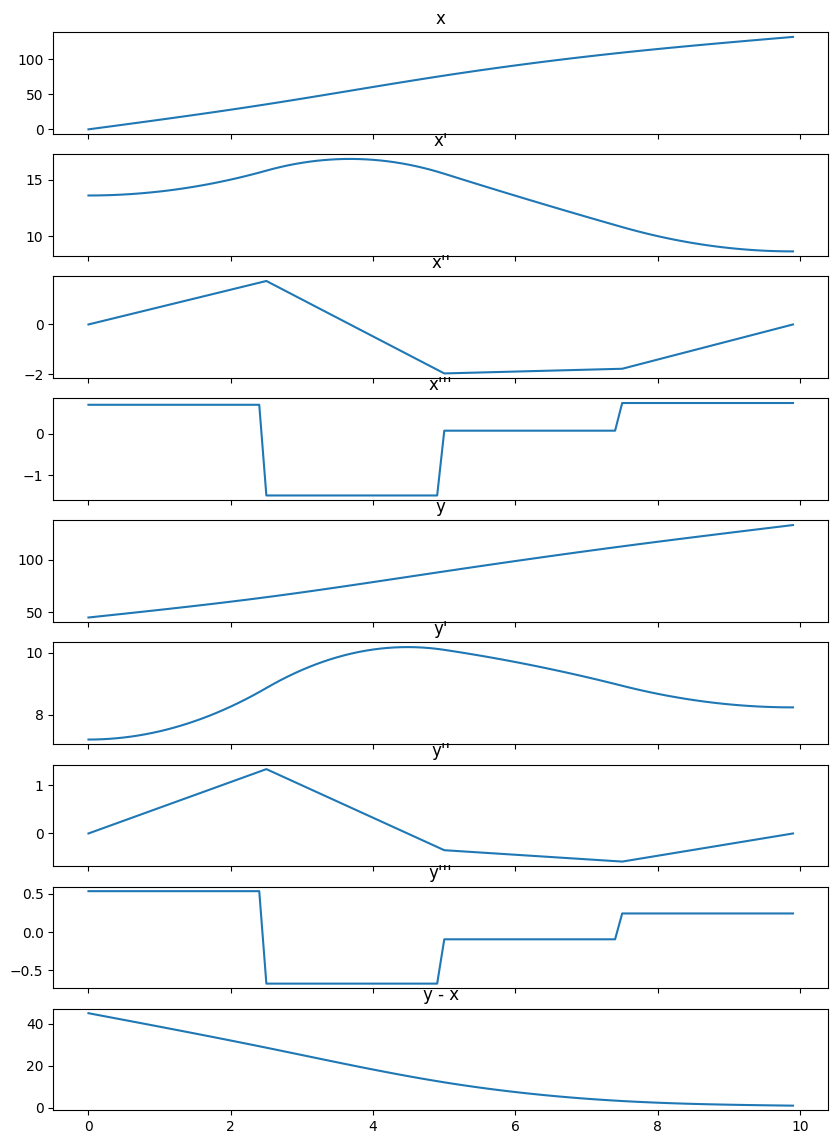

In [11]:
# Show the best signal

results = falsified_traces if len(falsified_traces) != 0 else history[:-5]

plot_trace(results[0], sharey=False, figsize=[10, 14])


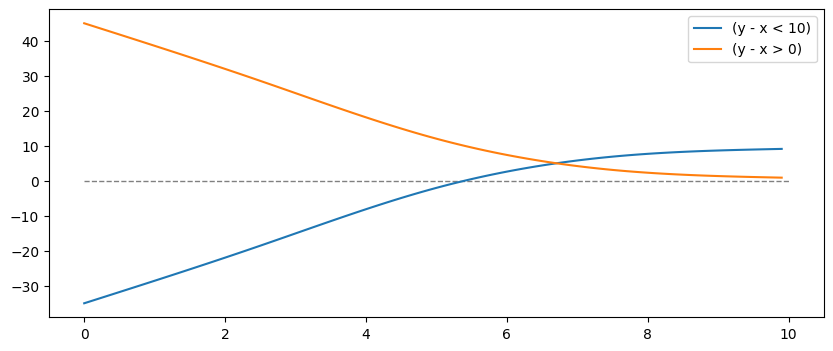

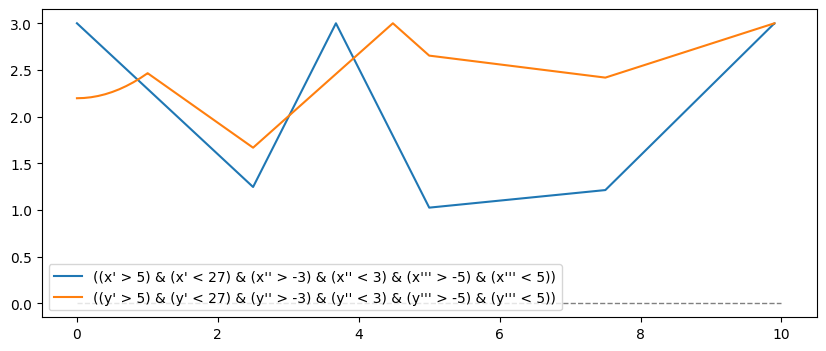

In [12]:
# See some subformulas are certainly as intended

plt.hlines(0, 0, time_horizon, color='gray', linestyle='--', linewidth=1)
plot_robustness(danger, results[0])
plot_robustness((Predicate("y - x") > 0), results[0])
plt.legend()
plt.show()

plt.hlines(0, 0, time_horizon, color='gray', linestyle='--', linewidth=1)
plot_robustness(carx, results[0])
plot_robustness(cary, results[0])
plt.legend()
plt.show()

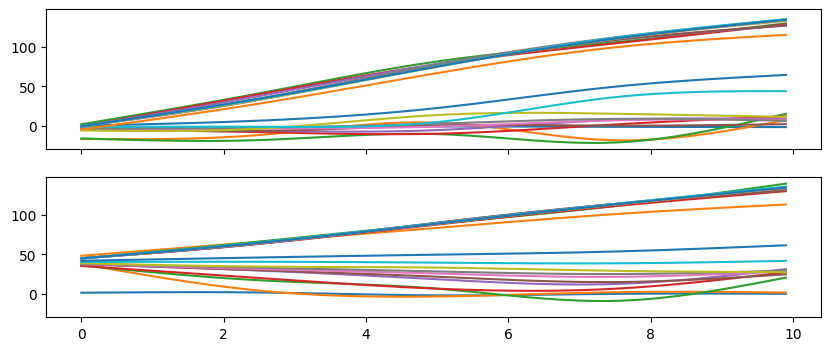

In [13]:
# Show some (5%) of all generated signals

def plot_traces_xy(traces, **figure_args):
    fig, ax = plt.subplots(2, sharex=True, sharey=True, **figure_args)
    for trace in traces:
        ax[0].plot(trace["x"].times, trace["x"].values)
        ax[1].plot(trace["y"].times, trace["y"].values)
traces = [trace for (_, trace, _) in history]
plot_traces_xy(traces[::len(traces)//20])